In this code, we assume the following notation for the Standard Hopfield model:
- N is the size of the patterns;
- M is the number of patterns that we want to store;
- $\xi^\mu \in [-1,1]^N$, is the $\mu$-th stored pattern, with $\mu = 1,...,M$;
- $\sigma \in [-1,1]^N$ is a generic configuration.

The coupling matrix is: 
$$ 
J_{ij} = \frac{1}{N}\sum_{\mu = 1}^{M} \xi^\mu_i \xi^\mu_j, \quad J_{ii} = 0.
$$

The energy of a given configuration $\sigma$ is given by:
$$
E(\sigma) = \frac{1}{2} \sum_{i,j} J_{ij}\sigma_i \sigma_j
$$

# Reconstruction probability
In order to compute the reconstruction probability, we proceed as follows:
- define a range of "perturb probability", for example `pp = range( 0.08, 0.58, length = 22 )`;
- then, for each $ p \in pp $:
    - generate a big number of indipendent samples $ \xi $ and initialize a counter;
        - select a random pattern from $ \xi $ perturb it with p and run the zero-temperatur Monte-Carlo;
        - if the final overlap with the original pattern is bigger or equal than 0.95, consider it as a success and update counter;
        - repeat for all the samples.
    - the reconstruction probability for $ p $ is just the fraction of successes.

In [1]:
include("standard_hopfield.jl")
using .SH, Statistics, LinearAlgebra, Plots
using DelimitedFiles, Random

In [2]:
function reconstruction_prob(N::Int, pp::AbstractVector, α, nsamples;
        nsweeps = 100, β = 10, earlystop = 0)
    
    M = round(Int, N * α)
    
    len_pp = length(pp)
    probs = zeros(len_pp)
    error_bars = zeros(len_pp)
    magnetization = zeros(len_pp)
    
    for i in 1:len_pp
        probs_over_samples = zeros(nsamples)        
        #count = 0
        ms = zeros(nsamples)
        
        for sample in 1:nsamples
            ξ = generate_patterns(M, N)
            J = store(ξ)
            
            k = rand(1:M)
            σ = ξ[:, k]
            σ_pert = perturb(σ, pp[i])
                        
            σ_rec = monte_carlo(J, σ_pert; nsweeps = nsweeps, earlystop = earlystop, β = β)
            
            m = overlap(σ_rec, σ)
            #print(m)
            if m >= 0.95
                probs_over_samples[sample] = 1
                #count += 1
            end
            ms[sample] = m
        end
        probs[i] = Statistics.mean(probs_over_samples)
        error_bars[i] = Statistics.std(probs_over_samples)/sqrt(nsamples)
        magnetization[i] = Statistics.mean(ms)
    end
    
    return probs, error_bars, magnetization
end

reconstruction_prob (generic function with 1 method)

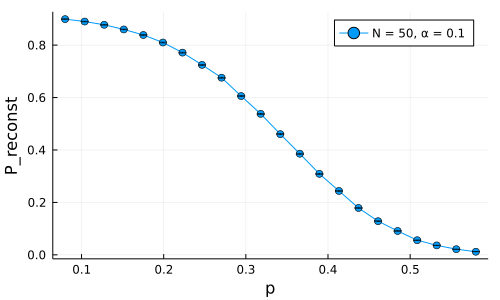

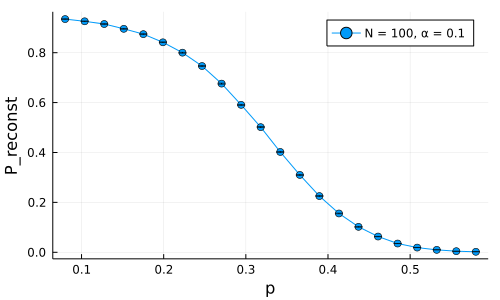

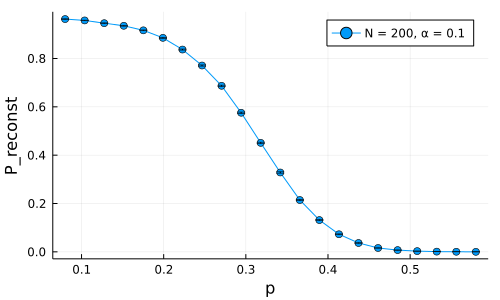

In [7]:
NN = [50, 100, 200]
pp = range( 0.08, 0.58, length = 22 )
α = 0.1
nsweeps = 100
β = 10^3
#nsamples = [10^6]*3 ./ NN
nsamples = [6*10^4, 5*10^4, 3*10^4]
#nsamples = map(Int, nsamples)
earlystop = 0

for i in 1:length(NN)
    N = NN[i]
    #println("Starting simulation for N = ", N, "\n")
    p, e, m = reconstruction_prob(N, pp, α, nsamples[i])
    
    fig = plot(pp, p, size = (500,300), markershape =:circle, label = "N = $N, α = $α",
        yerrors = e, xlabel = "p", ylabel = "P_reconst") 
    display(fig)
    
    io = open("julia_data/alpha_01/probsN"*"$N"*".txt", "w") do io
          writedlm(io, [pp p e m])
    end
    #println("Done!\n")
end

### Load the data

In [ ]:
P_90 = readdlm("julia_data/alpha_01/probsN90.txt", '\t', Float64, '\n')[:, 2]
P_100 = readdlm("julia_data/alpha_01/probsN100.txt", '\t', Float64, '\n')[:, 2]
P_110 = readdlm("julia_data/alpha_01/probsN110.txt", '\t', Float64, '\n')[:, 2]

In [16]:
nsamples = [10^6]*3 ./ NN

2-element Vector{Float64}:
 20000.0
 12000.0